In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua
import trajectory as trj

import h5py
import ray
import pyproj
# ray.init(num_cpus=7)


no config found


In [10]:
def trajectory_rmse(
    stats,
    year,
    month=False,
    sel_time=False,
    show_ascents=False,
    show_date=False,
    min_disp=0,
    compare_to="fc",
    diff=False,
):
    print("compare to: ", compare_to)
    maxtimediff = pd.Timedelta(hours=2)
    for stat in stats:
        t0 = time.time()
        statlist = glob.glob(
            "/mnt/users/scratch/leo/scratch/converted_v11/long/*"
            + stat
            + "*_CEUAS_merged_v1.nc"
        )
        print(statlist)
        df = eua.CDMDataset(filename=statlist[0]).to_dataframe(
            groups=["observations_table", "era5fb"],
            variables=[
                "latitude",
                "longitude",
                "observed_variable",
                "observation_value",
                "z_coordinate",
                "date_time",
                "fg_depar@body",
                "an_depar@body",
            ],
        )
        print("reading converted_v9: ", time.time() - t0)
        t0 = time.time()
        # 2020 only
        df = df[df.date_time.dt.year == year]
        # night only -> ~ 00:00
        if sel_time:
            df = df[np.isin(df.date_time.dt.hour, time)]
        print("selecting from converted_v9: ", time.time() - t0)
        t0 = time.time()

        from scipy.signal import savgol_filter

        # stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
        stdplevs = [
            1000,
            2000,
            3000,
            5000,
            7000,
            10000,
            15000,
            20000,
            25000,
            30000,
            40000,
            50000,
            70000,
            85000,
            92500,
        ]
        rmse_sum_shbase_sonde = {}
        rmse_sum_shdisp_sonde = {}
        rms_sum_shbase = {}
        rms_sum_sonde = {}
        rms_sum_shdisp = {}
        rms_sum_dispminusbase = {}

        for i in stdplevs:
            rmse_sum_shbase_sonde[i] = []
            rmse_sum_shdisp_sonde[i] = []
            rms_sum_shbase[i] = []
            rms_sum_sonde[i] = []
            rms_sum_shdisp[i] = []
            rms_sum_dispminusbase[i] = []

        if month == False:
            month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        else:
            month = [month]
        for m in month:
            print("month: ", m)
            t0 = time.time()
            if compare_to == "fc":
                files = glob.glob(
                    "/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct."
                    + str(year)
                    + str(m).zfill(2)
                    + "*.130.nc"
                )[0]
            else:
                files = glob.glob(
                    "/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t."
                    + str(year)
                    + str(m).zfill(2)
                    + "*.130.nc"
                )[0]
            ds_fc = xr.load_dataset(files)
            print("loading era5 data: ", time.time() - t0)
            t0 = time.time()
            df_mon = df[df.date_time.dt.month == m]
            print("selecting era5 data: ", time.time() - t0)
            t0 = time.time()

            for day in df_mon.date_time.drop_duplicates()[:]:
                try:
                    test = df_mon[df_mon.date_time == day]
                    if show_date:
                        print(day)

                    ds_fc_time = ds_fc.sel(time=day, method="nearest")
                    t0 = time.time()
                    if (pd.Timestamp(ds_fc_time.time.values) - day) > maxtimediff:
                        continue

                    t = test[test.observed_variable == 126]
                    t = t.rename(columns={"observation_value": "temperature"})
                    t = t.drop(columns="observed_variable")

                    u = test[test.observed_variable == 104]
                    u = u.rename(columns={"observation_value": "u"})
                    u = u.drop(
                        columns=["observed_variable", "fg_depar@body", "an_depar@body"]
                    )

                    v = test[test.observed_variable == 105]
                    v = v.rename(columns={"observation_value": "v"})
                    v = v.drop(
                        columns=["observed_variable", "fg_depar@body", "an_depar@body"]
                    )

                    input_data = pd.merge(
                        t, u, on=["z_coordinate", "latitude", "longitude", "date_time"]
                    )
                    input_data = pd.merge(
                        input_data,
                        v,
                        on=["z_coordinate", "latitude", "longitude", "date_time"],
                    )

                    input_data = input_data.dropna()
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    phys_model = trj.trajectory(
                        lat=t.latitude.iloc[0],
                        lon=t.longitude.iloc[0],
                        temperature=np.array(input_data.temperature),
                        u=np.array(input_data.u),
                        v=np.array(input_data.v),
                        pressure=np.array(input_data.z_coordinate),
                    )
                    if (np.abs(np.nanmax(phys_model[0])) < min_disp) and (
                        np.abs(np.nanmax(phys_model[1])) < min_disp
                    ):
                        continue
                    input_data["z"] = np.array(
                        trj.calc_height(
                            np.array(input_data.temperature),
                            np.array(input_data.z_coordinate),
                            jump=False,
                        )
                    )
                    input_data["calc_latd"] = np.array(phys_model[0])
                    input_data["calc_lond"] = np.array(phys_model[1])
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    input_data = input_data.reset_index()

                    t_list = []
                    for i in np.array(ds_fc_time.level):  # 10,20,...,1000
                        step = find_nearest(input_data.z_coordinate, i * 100)
                        input_data_step = input_data[input_data.z_coordinate == step]
                        station_lat = (
                            input_data.latitude[0]
                            + np.array(input_data_step.calc_latd)[0]
                        )
                        station_lon = (
                            input_data.longitude[0]
                            + np.array(input_data_step.calc_lond)[0]
                        )
                        lon = station_lon
                        if lon < 0:
                            lon = 360.0 + lon
                        ds_now = ds_fc_time.interp(
                            latitude=[station_lat], longitude=[lon], method="linear"
                        )
                        t = ds_now.t.sel(level=i)
                        t_list.append(float(t))

                    p_ml = [
                        1000,
                        2000,
                        3000,
                        5000,
                        7000,
                        10000,
                        15000,
                        20000,
                        25000,
                        30000,
                        40000,
                        50000,
                        70000,
                        85000,
                        92500,
                        100000,
                    ]
                    lon = input_data.longitude[0]
                    if lon < 0:
                        lon = 360.0 + lon
                    base_t = np.array(
                        ds_fc_time.interp(
                            latitude=[input_data.latitude[0]],
                            longitude=[lon],
                            method="linear",
                        ).t
                    )
                    for i in range(len(stdplevs)):
                        if (
                            np.abs(
                                stdplevs[i]
                                - find_nearest(input_data.z_coordinate, stdplevs[i])
                            )
                            > 500
                        ):
                            #                             print(stdplevs[i] , find_nearest(input_data.z_coordinate,stdplevs[i]))
                            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                            rms_sum_shbase[stdplevs[i]].append(np.nan)
                            rms_sum_sonde[stdplevs[i]].append(np.nan)
                            rms_sum_shdisp[stdplevs[i]].append(np.nan)
                            rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

                        else:
                            sq_t = np.squeeze(base_t)
                            t_base = float(
                                sq_t[p_ml == find_nearest(p_ml, stdplevs[i])]
                            )
                            t_disp = float(
                                np.array(t_list)[
                                    p_ml == find_nearest(p_ml, stdplevs[i])
                                ]
                            )
                            input_data_step = input_data[
                                input_data.z_coordinate
                                == find_nearest(input_data.z_coordinate, stdplevs[i])
                            ]
                            t_sonde = float(input_data_step.temperature)

                            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                            rms_sum_shbase[stdplevs[i]].append(t_base)
                            rms_sum_sonde[stdplevs[i]].append(t_sonde)
                            rms_sum_shdisp[stdplevs[i]].append(t_disp)
                            rms_sum_dispminusbase[stdplevs[i]].append(t_disp - t_base)

                    if show_ascents:
                        fig, ax1 = maplt.subplots(1, figsize=(16, 8))
                        #                         plt_sonde_t = []

                        #                         for pl in stdplevs:
                        base = []
                        disp = []
                        sond = []
                        plev = []
                        for i in range(len(stdplevs)):
                            base.append(rms_sum_shbase[stdplevs[i]][-1])
                            disp.append(rms_sum_shdisp[stdplevs[i]][-1])
                            sond.append(rms_sum_sonde[stdplevs[i]][-1])
                            plev.append(stdplevs[i])

                        ax1.plot(
                            np.array(base),
                            np.array(plev),
                            color="green",
                            alpha=0.6,
                            label="base tempterature",
                        )
                        ax1.plot(
                            np.array(disp),
                            np.array(plev),
                            color="blue",
                            alpha=0.2,
                            ls="--",
                            label="displaced temperature",
                        )
                        ax1.plot(
                            np.array(sond),
                            np.array(plev),
                            color="red",
                            alpha=0.2,
                            ls="--",
                            label="temperature radio sonde",
                        )
                        ax1.set_ylabel("pressure (Pa)")
                        ax1.set_xlabel("temperature (K)")
                        ax1.tick_params(axis="y")
                        ax1.set_ylim(ax1.get_ylim()[::-1])
                        ax1.legend()
                        ax1.grid()
                        maplt.show()
                        maplt.close()
                except:
                    pass
                print("done with all days: ", time.time() - t0)

        print("valid ascents: ", len(rms_sum_shdisp[50000]))
        t0 = time.time()
        rmse_shbase_sonde = []
        rmse_shdisp_sonde = []

        rms_shbase = []
        rms_sonde = []
        rms_shdisp = []
        rms_dispmbase = []

        for i in range(len(stdplevs)):
            rmse_shbase_sonde.append(
                np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]]) ** 2)))
            )
            rmse_shdisp_sonde.append(
                np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]]) ** 2)))
            )
            if show_date:
                print(
                    "rmse_shdisp_sonde - plev: ",
                    stdplevs[i],
                    " RMSE: ",
                    rmse_shdisp_sonde[-1],
                )
            rms_shbase.append(
                np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]]) ** 2)))
            )
            if show_date:
                print("rms_shbase - plev: ", stdplevs[i], " RMS: ", rms_shbase[-1])
            rms_sonde.append(
                np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]]) ** 2)))
            )
            if show_date:
                print("rms_sonde - plev: ", stdplevs[i], " RMS: ", rms_sonde[-1])
            rms_shdisp.append(
                np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]]) ** 2)))
            )
            if show_date:
                print("rms_shdisp - plev: ", stdplevs[i], " RMS: ", rms_shdisp[-1])
            rms_dispmbase.append(
                np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]]) ** 2)))
            )
            if show_date:
                print("rms_dispmbase - plev: ", stdplevs[i], " RMS: ", rms_shdisp[-1])
        print("")

        fig, ax1 = maplt.subplots(figsize=(15, 10))
        ax1.plot(
            np.array(rmse_shbase_sonde),
            stdplevs,
            color="orange",
            label="RMSE Undisplaced Sonde",
        )
        ax1.plot(
            np.array(rmse_shdisp_sonde),
            stdplevs,
            color="red",
            label="RMSE Displaced Sonde",
        )
        ax1_4 = ax1.twiny()
        ax1_4.axvline(x=0, color="black", alpha=0.8, ls="--", lw=0.5)
        if diff:
            ax1_4.plot(
                np.array(rmse_shbase_sonde) - np.array(rmse_shdisp_sonde),
                stdplevs,
                color="purple",
                label="Difference",
            )
        ax1_4.plot(
            np.array(rms_dispmbase),
            stdplevs,
            color="green",
            alpha=0.3,
            ls="--",
            label="RMS of Displaced - Base",
        )

        ax1_4.legend(loc="lower left")
        ax1.set_ylim(ax1.get_ylim()[::-1])
        ax1.set_ylabel("pressure (Pa)")
        ax1.set_xlabel("Temperature RMSE")
        ax1.legend(loc="upper right")
        ax1.grid()

        maplt.title(str(stat) + " LEVEL Temperature RMSE ")
        maplt.show()
        maplt.close()
        print("RMSE calculation: ", time.time() - t0)

compare to:  fc
['/mnt/users/scratch/leo/scratch/converted_v11/long/0-20001-0-11035_CEUAS_merged_v1.nc']
reading converted_v9:  378.5192985534668
selecting from converted_v9:  12.972686529159546
month:  1
loading era5 data:  2.725507974624634
selecting era5 data:  0.043381690979003906
done with all days:  0.12319493293762207
done with all days:  0.013533592224121094
done with all days:  0.007960081100463867
done with all days:  0.007783412933349609
done with all days:  0.007797718048095703
done with all days:  0.007885456085205078
done with all days:  0.007784128189086914
done with all days:  0.0077724456787109375
done with all days:  0.007734775543212891
done with all days:  0.007933616638183594
done with all days:  0.008276700973510742
done with all days:  0.007721662521362305
done with all days:  0.007796049118041992
done with all days:  0.007715463638305664
done with all days:  0.0077667236328125
done with all days:  0.007775068283081055
done with all days:  0.007772207260131836
do

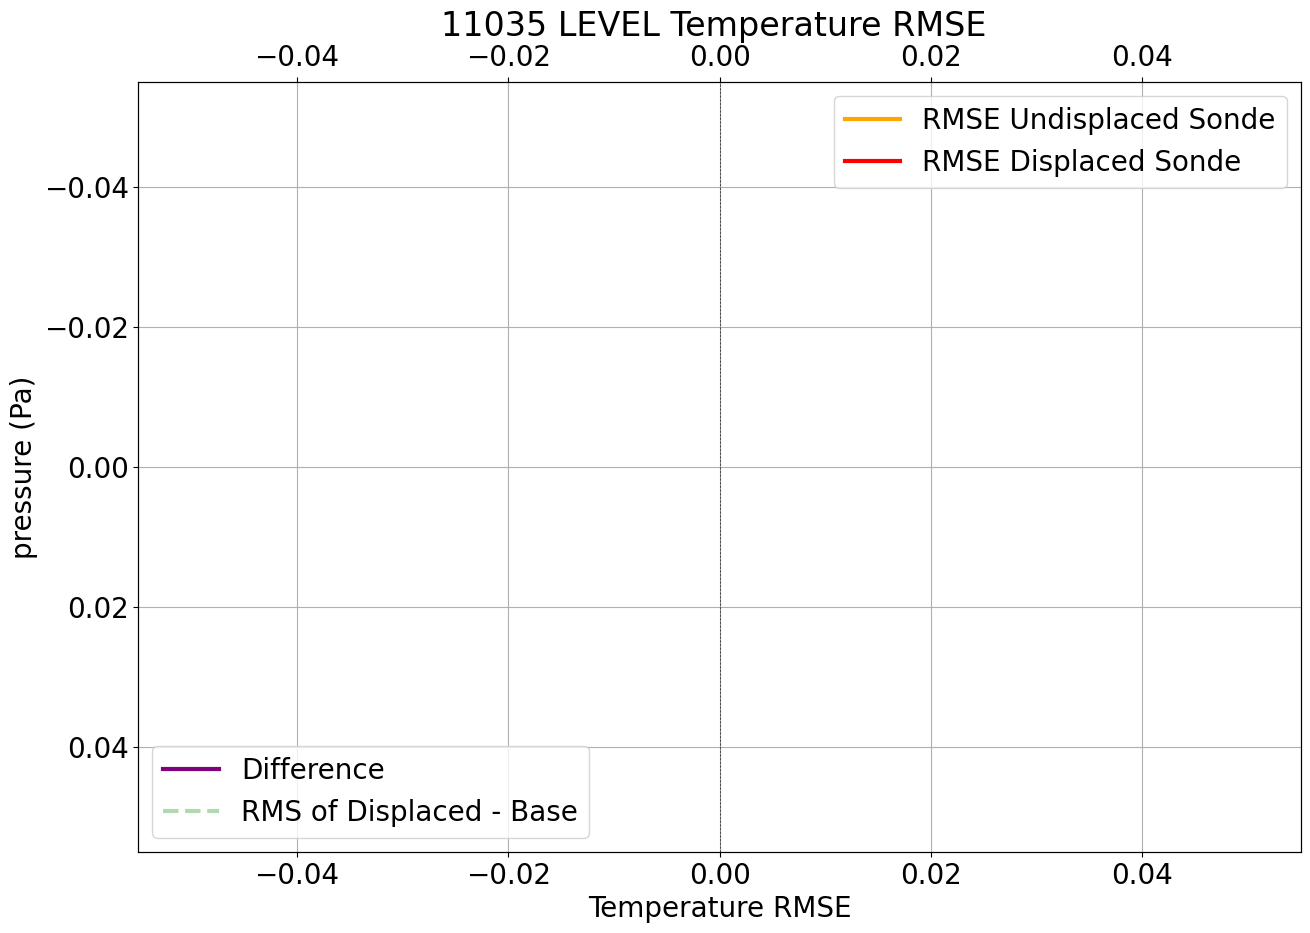

RMSE calculation:  0.4687385559082031


In [12]:
trajectory_rmse(
    stats=["11035"],
    year=2000,
    month=1,
    diff=True,
)

In [4]:
def single_plot_year_rmse(path, year, var, unit):
    
    import matplotlib
    import matplotlib.pylab as plt
    import matplotlib.pyplot as maplt
    matplotlib.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 3
    print('start')
    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
    diff = True
    show_date = False
    with open(path, 'rb') as file:
        results = pickle.load(file)
    print('file loaded')
    # rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde, rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde, rms_sum_shdisp, rms_sum_dispminusbase, xx = copy.deepcopy(results[0])
    rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde, rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde, rms_sum_shdisp, rms_sum_dispminusbase = copy.deepcopy(results[0])

    for i in results[1:]:
        if not (np.shape(i[0][50000]) == 0):
            for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
                rmse_sum_shbase_sonde[k]  = rmse_sum_shbase_sonde[k] + i[0][k]
                rmse_sum_shbase_adjsonde[k] = rmse_sum_shbase_adjsonde[k] + i[1][k]
                rmse_sum_shdisp_sonde[k] = rmse_sum_shdisp_sonde[k] + i[2][k]
                rmse_sum_shdisp_adjsonde[k] = rmse_sum_shdisp_adjsonde[k] + i[3][k]
                rms_sum_shbase[k] = rms_sum_shbase[k] + i[4][k]
                rms_sum_adjsonde[k] =  rms_sum_adjsonde[k] + i[5][k]
                rms_sum_sonde[k] = rms_sum_sonde[k] + i[6][k]
                rms_sum_shdisp[k] =  rms_sum_shdisp[k] + i[7][k]
                rms_sum_dispminusbase[k] = rms_sum_dispminusbase[k] + i[8][k]

    print('done opening')
        
    limit = [1,99]
    for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
        
        outlier_drop = np.nanpercentile(rmse_sum_shbase_sonde[k], limit)
        rmse_sum_shbase_sonde[k]  = np.array(rmse_sum_shbase_sonde[k])
        rmse_sum_shbase_sonde[k][(rmse_sum_shbase_sonde[k] < outlier_drop[0])] = np.nan
        rmse_sum_shbase_sonde[k][(rmse_sum_shbase_sonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_shbase_adjsonde[k], limit)
        rmse_sum_shbase_adjsonde[k]  = np.array(rmse_sum_shbase_adjsonde[k])
        rmse_sum_shbase_adjsonde[k][(rmse_sum_shbase_adjsonde[k] < outlier_drop[0])] = np.nan
        rmse_sum_shbase_adjsonde[k][(rmse_sum_shbase_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_shdisp_sonde[k], limit)
        rmse_sum_shdisp_sonde[k]  = np.array(rmse_sum_shdisp_sonde[k])
        rmse_sum_shdisp_sonde[k][(rmse_sum_shdisp_sonde[k] < outlier_drop[0])] = np.nan
        rmse_sum_shdisp_sonde[k][(rmse_sum_shdisp_sonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_shdisp_adjsonde[k], limit)
        rmse_sum_shdisp_adjsonde[k]  = np.array(rmse_sum_shdisp_adjsonde[k])
        rmse_sum_shdisp_adjsonde[k][(rmse_sum_shdisp_adjsonde[k] < outlier_drop[0])] = np.nan
        rmse_sum_shdisp_adjsonde[k][(rmse_sum_shdisp_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_shbase[k], limit)
        rms_sum_shbase[k]  = np.array(rms_sum_shbase[k])
        rms_sum_shbase[k][(rms_sum_shbase[k] < outlier_drop[0])] = np.nan
        rms_sum_shbase[k][(rms_sum_shbase[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_adjsonde[k], limit)
        rms_sum_adjsonde[k]  = np.array(rms_sum_adjsonde[k])
        rms_sum_adjsonde[k][(rms_sum_adjsonde[k] < outlier_drop[0])] = np.nan
        rms_sum_adjsonde[k][(rms_sum_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_sonde[k], limit)
        rms_sum_sonde[k]  = np.array(rms_sum_sonde[k])
        rms_sum_sonde[k][(rms_sum_sonde[k] < outlier_drop[0])] = np.nan
        rms_sum_sonde[k][(rms_sum_sonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_shdisp[k], limit)
        rms_sum_shdisp[k]  = np.array(rms_sum_shdisp[k])
        rms_sum_shdisp[k][(rms_sum_shdisp[k] < outlier_drop[0])] = np.nan
        rms_sum_shdisp[k][(rms_sum_shdisp[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_dispminusbase[k], limit)
        rms_sum_dispminusbase[k]  = np.array(rms_sum_dispminusbase[k])
        rms_sum_dispminusbase[k][(rms_sum_dispminusbase[k] < outlier_drop[0])] = np.nan
        rms_sum_dispminusbase[k][(rms_sum_dispminusbase[k] > outlier_drop[1])] = np.nan
        
    print('done outlier removal')
        
    print('valid ascents: ', len(rms_sum_shdisp[50000]))
    t0 = time.time()
    rmse_shbase_sonde=[]
    rmse_shbase_adjsonde=[]
    rmse_shdisp_sonde=[]
    rmse_shdisp_adjsonde=[]

    rms_shbase=[]
    rms_adjsonde=[]
    rms_sonde=[]
    rms_shdisp=[]
    rms_dispmbase=[]

    for i in range(len(stdplevs)):
        print('calc: ', i)
        rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
        rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
        rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
        rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

        rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
        if show_date:    
            print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
        rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
        rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
        rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
        if show_date:
            print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
        rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
        if show_date:
            print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


    print('')

    fig, ax = maplt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize = (15,10))
#     fig, ax1 = maplt.subplots(1, 1, figsize = (15,10))
    ax1 = ax[0]
    ax2 = ax[1] 
    ax2.sharey(ax1)
    ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='RMSE Undisplaced Sonde')
    ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='RMSE Displaced Sonde')

    ax1_4 = ax1.twiny()
    ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
    if diff:
        ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='Difference')
    # ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='RMS Diplaced - Undisplaced')

    ax1_4.legend(loc='upper right')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel(var +' RMSE ['+unit+']')
    ax1.legend(loc='lower right')
    ax1.grid()
    
    value_nr = []
    for i in rmse_sum_shbase_sonde:
        value_nr.append(len(rmse_sum_shbase_sonde[i][~np.isnan(rmse_sum_shbase_sonde[i])]))
#     print(value_nr)
#     print(stdplevs)
    ax2.barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
    ax2.set_xlabel('Observations')
#     ax2.set_yticklabels([])
    ax2.tick_params(labelleft=False)
    ax2.grid()

#         maplt.title(str(year)+' Temperature RMSE \n' + str(len(results)) + ' stations    ' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
    maplt.title(str(year)+' '+var+' RMSE \n' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
    maplt.tight_layout()
#     for axis in fig.gcf().axes:
#         try:
#             ax.label_outer()
#         except:
#             pass
    maplt.savefig(str(year)+'_era5_fc_outlier_cleaned_world_rmse_plot_'+var+'.png')
    maplt.show()
    maplt.close()
    return 

start
file loaded
done opening
done outlier removal
valid ascents:  360269
calc:  0
calc:  1
calc:  2
calc:  3
calc:  4
calc:  5
calc:  6
calc:  7
calc:  8
calc:  9
calc:  10
calc:  11
calc:  12
calc:  13
calc:  14



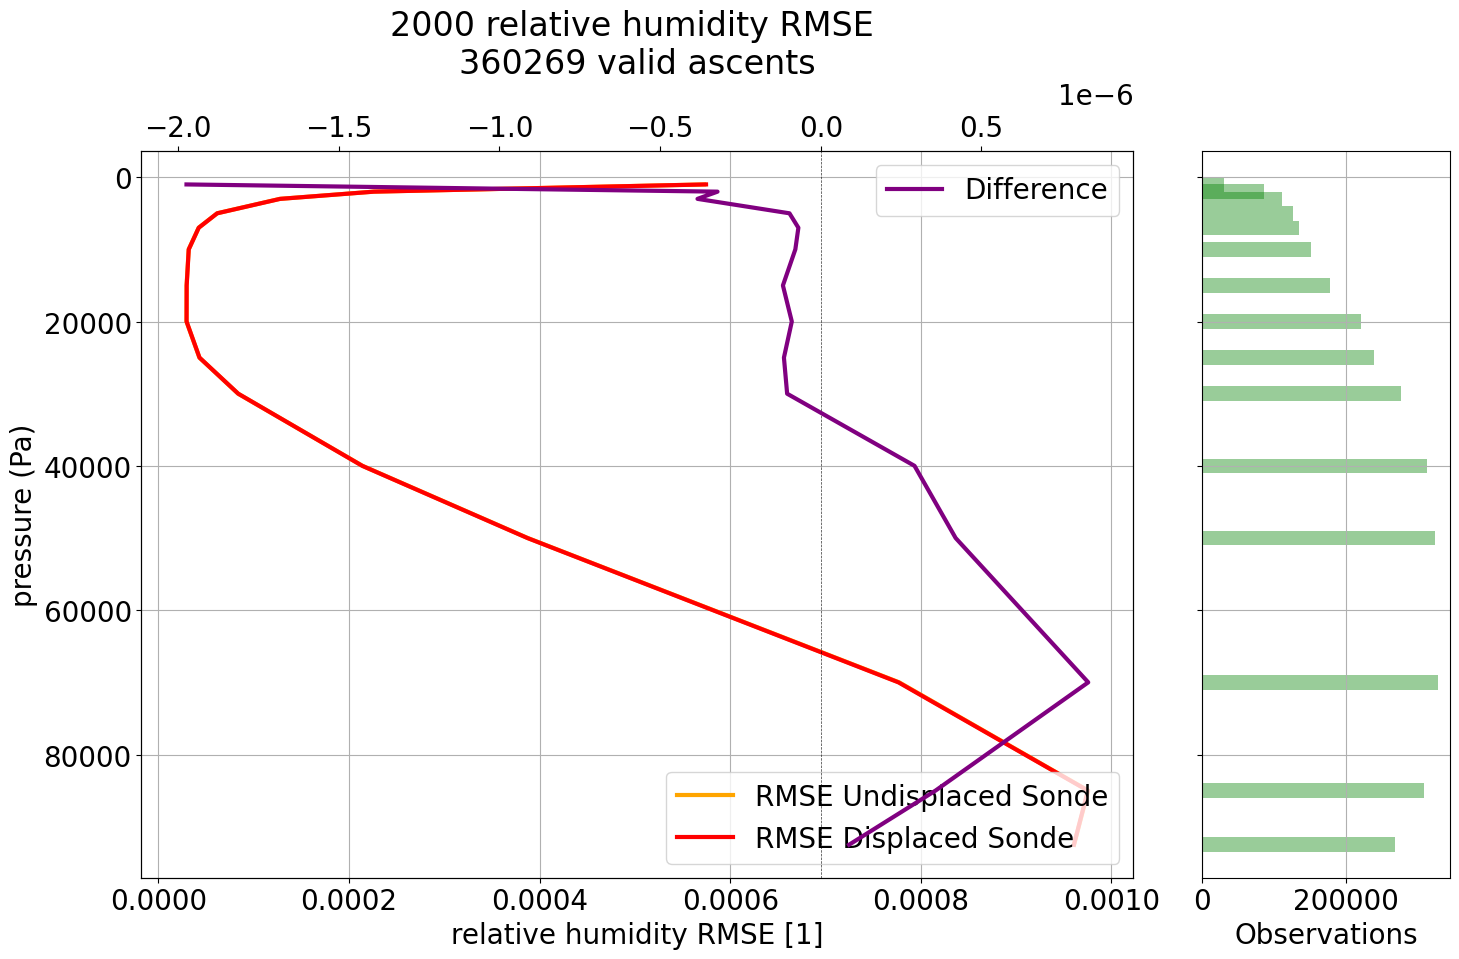

In [5]:
path =  './rmse_fc/era5_u_fc_2000_rmse_data.p' # './pre_calculated_rms data/era5_v_fc_2000_rmse_data.p'
var = 'relative humidity'
unit = 'm/s'
year = '2000'
single_plot_year_rmse(path, year, var, unit)
